## Setup

### Data

In [1]:
# Read the sleep data file 
import json
import pandas as pd
import glob

# Find all JSON files in current folder
files = glob.glob('*.json')
print(f"Found {len(files)} JSON files:")
for file in files:
    print(f"  - {file}")

# Load and combine all files
all_data = []

for file in files:
    with open(file, 'r') as f:
        data = json.load(f)
        all_data.extend(data)
    print(f"✓ Loaded {len(data)} records from {file}")

# Convert to DataFrame
df = pd.DataFrame(all_data)

Found 7 JSON files:
  - 2025-03-31_2025-07-09_117339697_sleepData.json
  - 2024-12-21_2025-03-31_117339697_sleepData.json
  - 2024-02-25_2024-06-04_117339697_sleepData.json
  - 2023-11-17_2024-02-25_117339697_sleepData.json
  - 2024-09-12_2024-12-21_117339697_sleepData.json
  - 2025-07-09_2025-10-17_117339697_sleepData.json
  - 2024-06-04_2024-09-12_117339697_sleepData.json
✓ Loaded 95 records from 2025-03-31_2025-07-09_117339697_sleepData.json
✓ Loaded 97 records from 2024-12-21_2025-03-31_117339697_sleepData.json
✓ Loaded 56 records from 2024-02-25_2024-06-04_117339697_sleepData.json
✓ Loaded 64 records from 2023-11-17_2024-02-25_117339697_sleepData.json
✓ Loaded 94 records from 2024-09-12_2024-12-21_117339697_sleepData.json
✓ Loaded 94 records from 2025-07-09_2025-10-17_117339697_sleepData.json
✓ Loaded 90 records from 2024-06-04_2024-09-12_117339697_sleepData.json


In [2]:
# Convert sleep date column to datetime
df['date'] = pd.to_datetime(df['calendarDate'])
df['year'] = df['date'].dt.year                              
df['month'] = df['date'].dt.month                            
df['month_name'] = df['date'].dt.strftime('%B')              
df['year_month'] = df['date'].dt.strftime('%Y-%m')           
df['day_of_month'] = df['date'].dt.day  
df['day_of_week'] = df['date'].dt.day_name()
df['weekday_num'] = df['date'].dt.weekday                  
df['week_of_month'] = (df['day_of_month'] - 1) // 7        

# Convert sleep durations from seconds to hours
df['deep_sleep_hours'] = df['deepSleepSeconds'] / 3600
df['light_sleep_hours'] = df['lightSleepSeconds'] / 3600
df['rem_sleep_hours'] = df['remSleepSeconds'] / 3600
df['awake_hours'] = df['awakeSleepSeconds'] / 3600

# Calculate total sleep
df['total_sleep_hours'] = df['deep_sleep_hours'] + df['light_sleep_hours'] + df['rem_sleep_hours']

# Extract overall sleep score
df['overall_score'] = df['sleepScores'].apply(lambda x: x['overallScore'] if isinstance(x, dict) else None)

print(f"✓ Date range: {df['date'].min().date()} to {df['date'].max().date()}")

total_days_in_range = (df['date'].max() - df['date'].min()).days + 1
print(f"✓ Total days in range: {total_days_in_range}")
print(f"✓ Total days of sleep data: {len(df)}")

✓ Date range: 2023-11-17 to 2025-10-16
✓ Total days in range: 700
✓ Total days of sleep data: 590


In [3]:
# Read the Irma date ranges file 
import pandas as pd

irma_dates = pd.read_csv('Irma_dates - Sheet1.tsv', sep='\t')
print("Irma data is ready")

Irma data is ready


In [4]:
# Convert Irma date strings to datetime
date_format = '%d-%m-%Y'

# Convert all date columns to datetime
for col in irma_dates.columns:
    irma_dates[col] = pd.to_datetime(irma_dates[col], format=date_format)

# Function to determine which category a date falls into
def get_cycle_category(date):
    """
    Returns the cycle category for a given date.
    Categories: 'Free', 'Eggy', 'PMS', 'Irma', or None
    """
    for idx, row in irma_dates.iterrows():
        # Check Free
        if row['Free 👍 From'] <= date <= row['Free 👍 To']:
            return 'Free'
        # Check Ov
        if row['Eggy 🥚 From'] <= date <= row['Eggy 🥚 To']:
            return 'Eggy'
        # Check PMS
        if row['Pms 🥲 From'] <= date <= row['Pms 🥲 To']:
            return 'PMS'
        # Check Irma
        if row['Irma ❤️ From'] <= date <= row['Irma ❤️ To']:
            return 'Irma'
    
    return None  # Date not in any category

# Add category column to your main dataframe
df['cycle_category'] = df['date'].apply(get_cycle_category)

print("✓ Cycle categories added to dataframe")
print("\nCategory distribution:")
print(df['cycle_category'].value_counts())

✓ Cycle categories added to dataframe

Category distribution:
cycle_category
Free    223
Eggy    150
PMS     141
Irma     65
Name: count, dtype: int64


### Styleguide

In [5]:
# Style dictionary for all charts
COLOR_SCALES = {
    'sleep_score': [
        [0, '#D65D00'],                      # dark orange
        #[0.05, '#FF8C52'],                  # light orange
        #[0.15, 'rgba(255, 140, 82, 0.2)'],  # transparent orange
        [0.4, 'rgba(139, 160, 252, 0.2)'],   # transparent blue
        [0.9, '#2B36A4'],                    # light blue
        [1, '#000A73']                       # dark blue
    ], 
    
    'low_score': [
        [0, '#FF6416'],                      # dark orange (lowest)
        [1, 'rgba(255, 140, 82, 0.3)']       # transparent orange (low mid)
    ],
    
    'high_score': [
        [0, 'rgba(139, 160, 252, 0.2)'],       # transparent blue (high mid)
        [1, '#2C4DD0']                       # dark blue (highest)
    ],
    
    'cycle_categories': {
        'Free': '#45B067',   # green
        'Eggy': '#FFFDEF',   # white
        'PMS': '#FFE850',    # yellow
        'Irma': '#DB496B',   # pinkish red
        None: '#D3D3D3'
    },

    'missing_data': 'rgba(150, 150, 150, 0.1)', # Translucent gray for missing data
    'plot_bg': 'rgba(97, 108, 132, 0.1)',      # Translucent gray background for the plot area
    'paper_bg': 'rgba(0,0,0,0)', #'#080B1A',     # Dark background for the entire figure
    'gridlines': 'rgba(97, 108, 132, 0.5)',
    'guidelines': 'rgba(97, 108, 132, 0.5)',

    'bar_outline': {
        'color': '#131F3C',    # Same as plot_bg
        'width': 1
    },
    
    'title_font': {
        'size': 20,
        'color': '#DAE2FF',
        'family': 'Arial, sans-serif'
    },
    'axis_font': {
        'size': 10,
        'color': '#B5C5FF',
        'family': 'Arial, sans-serif'
    },
    'hover_font': {
        'size': 12,
        'family': 'Arial, sans-serif'
    }
}

# Cycle phase emoji mapping
CYCLE_EMOJIS = {
    'Free': '🍀',
    'Eggy': '🥚',
    'PMS': '🥲',
    'Irma': '❤️',
    None: ''
}

In [6]:
# Chart styling function
def get_chart_style():
    """Returns a dictionary of layout settings with all color configurations"""
    return {
        'plot_bgcolor': COLOR_SCALES['plot_bg'],
        'paper_bgcolor': COLOR_SCALES['paper_bg'],
        'font': COLOR_SCALES['axis_font'],
        'title': dict(
            font=COLOR_SCALES['title_font'],
            x=0.5,
            xanchor='center'
        ),
        # REMOVE the hoverlabel section
        'xaxis': dict(
            gridcolor=COLOR_SCALES['gridlines'],
            gridwidth=1,
            linecolor=COLOR_SCALES['gridlines'],
            titlefont=COLOR_SCALES['axis_font'],
            zeroline=False,
        ),
        'yaxis': dict(
            gridcolor=COLOR_SCALES['gridlines'],
            gridwidth=1,
            linecolor=COLOR_SCALES['gridlines'],
            titlefont=COLOR_SCALES['axis_font'],
            zeroline=False,
        )
    }

In [7]:
# Colour gradient across Irma phases
def hex_to_rgb(hex_color):
    """Convert hex color to RGB tuple"""
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    """Convert RGB tuple to hex color"""
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def hex_to_rgba(hex_color, alpha=0.5):  
    """Convert hex color to rgba with transparency"""
    hex_color = hex_color.lstrip('#')
    r, g, b = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    return f'rgba({r}, {g}, {b}, {alpha})'

def interpolate_color(color1, color2, factor):
    """
    Interpolate between two colors.
    factor: 0.0 returns color1, 1.0 returns color2, 0.5 returns middle
    """
    rgb1 = hex_to_rgb(color1)
    rgb2 = hex_to_rgb(color2)
    
    rgb = tuple(rgb1[i] + factor * (rgb2[i] - rgb1[i]) for i in range(3))
    return rgb_to_hex(rgb)

def get_gradient_color_for_date(date, irma_dates, category_colors):
    """
    Get a gradient color for a date based on its position within the cycle phase.
    Each phase (except Irma) transitions FROM previous phase in its first 30%.
    """
    for idx, row in irma_dates.iterrows():
        # Check if in Irma phase - solid color
        if row['Irma ❤️ From'] <= date <= row['Irma ❤️ To']:
            return category_colors['Irma']  # Solid red
        
        # Check Free phase - gradient in FIRST 30% (from Irma)
        if row['Free 👍 From'] <= date <= row['Free 👍 To']:
            phase_length = (row['Free 👍 To'] - row['Free 👍 From']).days + 1
            days_into_phase = (date - row['Free 👍 From']).days
            position = days_into_phase / phase_length
            
            if position < 0.3:
                # First 30%: transition from Irma to Free
                transition_factor = position / 0.3  # 0.0 to 1.0
                return interpolate_color(category_colors['Irma'], category_colors['Free'], transition_factor)   
            else:
                # Rest: solid Free color
                return category_colors['Free']
        
        # Check Eggy phase - gradient in FIRST 30% (from Free) and LAST 30% (to PMS)
        if row['Eggy 🥚 From'] <= date <= row['Eggy 🥚 To']:
            phase_length = (row['Eggy 🥚 To'] - row['Eggy 🥚 From']).days + 1
            days_into_phase = (date - row['Eggy 🥚 From']).days
            position = days_into_phase / phase_length
            
            if position < 0.3:
                # First 30%: transition from Free to Ov
                transition_factor = position / 0.3
                return interpolate_color(category_colors['Free'], category_colors['Eggy'], transition_factor)
            elif position > 0.7:
                # Last 30%: transition from Eggyto PMS
                transition_factor = (position - 0.7) / 0.3
                return interpolate_color(category_colors['Eggy'], category_colors['PMS'], transition_factor)
            else:
                # Middle: solid Eggycolor
                return category_colors['Eggy']
        
        # Check PMS phase - last 30% transitions to Irma
        if row['Pms 🥲 From'] <= date <= row['Pms 🥲 To']:
            phase_length = (row['Pms 🥲 To'] - row['Pms 🥲 From']).days + 1
            days_into_phase = (date - row['Pms 🥲 From']).days
            position = days_into_phase / phase_length
            
            if position > 0.7:
                # Last 30%: transition from PMS to Irma
                transition_factor = (position - 0.7) / 0.3
                return interpolate_color(category_colors['PMS'], category_colors['Irma'], transition_factor)
            else:
                # Solid PMS color
                return category_colors['PMS']
    
    return '#D3D3D3'  # Gray for uncategorized

# Define colors for each cycle category
category_colors = COLOR_SCALES['cycle_categories']

print("✓ Category colors defined")

print("✓ Gradient: Transitions happen at START of receiving phase (except PMS→Irma at end)")

✓ Category colors defined
✓ Gradient: Transitions happen at START of receiving phase (except PMS→Irma at end)


### Chart functions

In [8]:
# Circular calendar grid function
import plotly.graph_objects as go
import numpy as np
import pandas as pd

def create_circular_calendar_grid(df, metric_column, year, title, show_cycle_dots=True):
    
    # Filter to specific year
    df_year = df[df['year'] == year].copy()
    
    if len(df_year) == 0:
        print(f"No data found for year {year}")
        return None
    
    # Get color scale values
    vmin = df[metric_column].min()
    vmax = df[metric_column].max()
    
    # Create color mapper
    import plotly.express as px
    colorscale_values = px.colors.sample_colorscale(COLOR_SCALES['sleep_score'], 100)
    
    def get_color(value):
        if pd.isna(value):
            return COLOR_SCALES['missing_data']
        normalized = (value - vmin) / (vmax - vmin)
        idx = int(normalized * 99)
        return colorscale_values[idx]
    
    fig = go.Figure()
    
    # Month names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Day names (full for hover text)
    day_names_full = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    # Day names (single letter for labels)
    day_names_short = ['M', 'T', 'W', 'T', 'F', 'S', 'S']
    
    # Dimensions
    center_radius = 2
    outer_radius = 9
    ring_width = (outer_radius - center_radius) / 7  # 7 rings for days of week

    
    # Reserve space for weekday label slice
    label_slice_width = 14  # degrees
    label_slice_start = -7   # at 3 o'clock
    usable_degrees = 360 - label_slice_width
    degrees_per_month = usable_degrees / 12
    offset_angle = -7  # Start from 0° (the gap will be created by going backwards)
    
    # Create grid for each month
    for month in range(1, 13):
        month_data = df_year[df_year['month'] == month].copy()
        
        # Month slice angles (shifted to avoid label area)
        month_start_angle = offset_angle - (month - 1) * degrees_per_month
        month_end_angle = offset_angle - month * degrees_per_month
        angle_per_week = degrees_per_month / 5  # 5 weeks per month
        
        # Create cells for each week and day
        for week in range(5):  # 5 weeks
            for weekday in range(7):  # 7 days (Mon=0 to Sun=6)
                
                # Find data for this week and weekday in this month
                cell_data = month_data[
                    (month_data['week_of_month'] == week) & 
                    (month_data['weekday_num'] == weekday)
                ]
                
                if len(cell_data) > 0:
                    value = cell_data.iloc[0][metric_column]
                    date_str = cell_data.iloc[0]['date'].strftime('%b %d, %Y')
                    day_name = cell_data.iloc[0]['day_of_week']
                    day_num = cell_data.iloc[0]['day_of_month']
                    cycle_cat = cell_data.iloc[0].get('cycle_category', None)
                else:
                    value = np.nan
                    date_str = ''
                    day_name = day_names_full[weekday]
                    day_num = ''
                    cycle_cat = None
                
                # Calculate angles for this week within the month
                angle_start = month_start_angle - week * angle_per_week
                angle_end = month_start_angle - (week + 1) * angle_per_week
                
                # Swap since we're going clockwise
                angle_start, angle_end = angle_end, angle_start
                
                # Calculate radii for this weekday
                radius_inner = center_radius + weekday * ring_width
                radius_outer = center_radius + (weekday + 1) * ring_width
                
                # Convert to radians (subtract 90 to start at top)
                theta_start = np.radians(angle_start - 90 + 180)
                theta_end = np.radians(angle_end - 90 + 180)
                
                # Create cell shape
                n_points = 15
                theta_range = np.linspace(theta_start, theta_end, n_points)
                
                # Outer arc
                x_outer = radius_outer * np.cos(theta_range)
                y_outer = radius_outer * np.sin(theta_range)
                
                # Inner arc (reversed)
                x_inner = radius_inner * np.cos(theta_range[::-1])
                y_inner = radius_inner * np.sin(theta_range[::-1])
                
                # Combine to close the shape
                x_cell = np.concatenate([x_outer, x_inner, [x_outer[0]]])
                y_cell = np.concatenate([y_outer, y_inner, [y_outer[0]]])
                
                # Get color
                color = get_color(value)
                
                # Create hover text
                if not pd.isna(value):
                    if cycle_cat:
                        emoji = CYCLE_EMOJIS.get(cycle_cat, '')
                        cycle_label = f"<br>Phase: {emoji} {cycle_cat}"
                    else:
                        cycle_label = ""
                    hover_text = f"{date_str}<br>{day_name}<br>{metric_column}: {value:.2f}{cycle_label}"
                else:
                    hover_text = f"{month_names[month-1]} - Week {week+1}<br>{day_name}<br>No data"
                
                # Add cell
                fig.add_trace(go.Scatter(
                    x=x_cell,
                    y=y_cell,
                    fill='toself',
                    fillcolor=color,
                    line=dict(color=COLOR_SCALES['gridlines'], width=0.5),
                    text=hover_text,
                    hovertemplate='%{text}<extra></extra>',
                    showlegend=False,
                    mode='lines',
                    name=''
                ))

                # Add cycle phase dot
                if cycle_cat is not None and show_cycle_dots:
                    # Use the average of the cell's coordinates for the center
                    center_x = np.mean(x_cell[:-1])  # Exclude last point (duplicate)
                    center_y = np.mean(y_cell[:-1])
                    
                    # Get color for this cycle category
                    dot_color = COLOR_SCALES['cycle_categories'].get(cycle_cat, '#D3D3D3')
                    
                    # Add dot
                    fig.add_trace(go.Scatter(
                        x=[center_x],
                        y=[center_y],
                        mode='markers',
                        marker=dict(
                            size=4,
                            color=dot_color,
                            line=dict(width=0.1)
                        ),
                        hoverinfo='skip',
                        showlegend=False
                    ))

    # Add weekday label slice (0° to 20°, at 3 o'clock)
    for weekday in range(7):
        # Calculate radii for this weekday ring
        radius_inner = center_radius + weekday * ring_width
        radius_outer = center_radius + (weekday + 1) * ring_width
        radius_mid = (radius_inner + radius_outer) / 2
        
        # Draw background cell for label
        theta_start = np.radians(label_slice_start - 90 + 180)
        theta_end = np.radians(offset_angle - 90 + 180)
        
        n_points = 10
        theta_range = np.linspace(theta_start, theta_end, n_points)
        
        x_outer = radius_outer * np.cos(theta_range)
        y_outer = radius_outer * np.sin(theta_range)
        x_inner = radius_inner * np.cos(theta_range[::-1])
        y_inner = radius_inner * np.sin(theta_range[::-1])
        
        x_bg = np.concatenate([x_outer, x_inner, [x_outer[0]]])
        y_bg = np.concatenate([y_outer, y_inner, [y_outer[0]]])
        
        # Add background cell for label
        fig.add_trace(go.Scatter(
            x=x_bg,
            y=y_bg,
            fill='toself',
            fillcolor=COLOR_SCALES['plot_bg'],
            line=dict(color=COLOR_SCALES['gridlines'], width=1),
            hoverinfo='skip',
            showlegend=False,
            mode='lines',
            name=''
        ))
        
        # Add label text
        angle_mid = 90
        theta_mid = np.radians(angle_mid)
        
        x_label = radius_mid * np.cos(theta_mid)
        y_label = radius_mid * np.sin(theta_mid)
        
        fig.add_annotation(
            x=x_label,
            y=y_label,
            text=f"<b>{day_names_short[weekday]}</b>",
            showarrow=False,
            font=dict(size=10, color=COLOR_SCALES['axis_font']['color']),
            xanchor='center',
            yanchor='middle'
        )
    
    # Add month labels with arched backgrounds
    label_bg_radius_inner = outer_radius + 0.3
    label_bg_radius_outer = outer_radius + 1.3
            
    # Calculate month boundaries based on calendar
    import calendar
    
    month_angles = {}
    
    for month in range(1, 13):
        # Calculate angles (starting from offset, going clockwise)
        angle_end = offset_angle - (month - 1) * degrees_per_month - 90 + 180
        angle_start = offset_angle - month * degrees_per_month - 90 + 180
        
        month_angles[month] = {
            'start': angle_start,
            'end': angle_end,
            'name': month_names[month-1]
        }
    
    # Draw month label backgrounds and text
    for month, info in month_angles.items():
        angle_start = info['start']
        angle_end = info['end']
        month_name = info['name']
        
        # Create arched background
        theta_start = np.radians(angle_start)
        theta_end = np.radians(angle_end)
        
        n_points = 30
        theta_range = np.linspace(theta_start, theta_end, n_points)
        
        # Outer arc
        x_outer = label_bg_radius_outer * np.cos(theta_range)
        y_outer = label_bg_radius_outer * np.sin(theta_range)
        
        # Inner arc (reversed)
        x_inner = label_bg_radius_inner * np.cos(theta_range[::-1])
        y_inner = label_bg_radius_inner * np.sin(theta_range[::-1])
        
        # Combine
        x_bg = np.concatenate([x_outer, x_inner, [x_outer[0]]])
        y_bg = np.concatenate([y_outer, y_inner, [y_outer[0]]])
        
        # Add background
        fig.add_trace(go.Scatter(
            x=x_bg,
            y=y_bg,
            fill='toself',
            fillcolor=COLOR_SCALES['plot_bg'],
            line=dict(color=COLOR_SCALES['gridlines'], width=1),
            hoverinfo='skip',
            showlegend=False,
            mode='lines',
            name=''
        ))
        
        # Add month label text
        angle_mid = (angle_start + angle_end) / 2
        theta_mid = np.radians(angle_mid)
        
        label_radius = (label_bg_radius_inner + label_bg_radius_outer) / 2
        x_label = label_radius * np.cos(theta_mid)
        y_label = label_radius * np.sin(theta_mid)
        
        fig.add_annotation(
            x=x_label,
            y=y_label,
            text=f"{month_names[month-1]}",
            showarrow=False,
            font=dict(size=10, color=COLOR_SCALES['axis_font']['color']),
            xanchor='center',
            yanchor='middle'
        )

    # Add center year label
    fig.add_annotation(
        x=0,
        y=0,
        text=f"<b>{year}</b>",
        showarrow=False,
        font=dict(size=28, color=COLOR_SCALES['title_font']['color']),
        xanchor='center',
        yanchor='middle'
    )

    # Update layout
    fig.update_layout(
        #title=dict(text=title, font=COLOR_SCALES['title_font']),
        width=1000,
        height=1000,
        margin=dict(t=0, b=200, l=0, r=0, pad=0),  # Bottom margin for legends
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        hovermode='closest',
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            range=[-11.5, 11.5]
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            range=[-12, 12],
            scaleanchor='x',
            scaleratio=1
        ),

    )

    add_colorbar_legend(fig, y_position=-0.12)  # Legend for sleep score
    add_cycle_legend(fig, y_position=-12)  # Legend for Irma phases

    # Add custom HTML/CSS to center the chart
    html_string = fig.to_html(include_plotlyjs='cdn', config={'displayModeBar': False})
    
    # Inject centering CSS
    centered_html = html_string.replace(
        '<body>',
        '<body style="display: flex; justify-content: center; align-items: center; margin: 0; padding: 0; min-height: 100vh;">'
    )
    
    # Write to file
    with open("circular_calendar.html", "w") as f:
        f.write(centered_html)
        
    return fig

In [9]:
# Radial bar chart funcion
import plotly.graph_objects as go
import numpy as np
import pandas as pd

def create_radial_bar_calendar(df, metric_column, year, title, show_stats=False):
    import calendar
    
    # Filter to specific year
    df_year = df[df['year'] == year].copy()
    
    if len(df_year) == 0:
        print(f"No data found for year {year}")
        return None
    
    # Sort by date to ensure proper ordering
    df_year = df_year.sort_values('date').reset_index(drop=True)
    
    # Month names
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Dimensions
    center_radius = 2.5  # Empty space in center
    outer_radius = 9  # Maximum bar length (for score of 100)

    fig = go.Figure()
    
    # Reserve space for score label slice at 12 o'clock
    label_slice_width = 14  # degrees (7° on each side of 12 o'clock)
    label_slice_start = 90 + 7   # right edge of slice (97°)
    label_slice_end = 90 - 7     # left edge of slice (83°)
    
    # Add concentric circles at intervals of 10 (scale rings)
    for score_value in range(0, 101, 10):
        # Calculate radius for this score
        radius = center_radius + (score_value / 100) * (outer_radius - center_radius)
        
        # Create circle
        theta_circle = np.linspace(0, 2*np.pi, 200)
        x_circle = radius * np.cos(theta_circle)
        y_circle = radius * np.sin(theta_circle)
        
        # Add circle
        fig.add_trace(go.Scatter(
            x=x_circle,
            y=y_circle,
            mode='lines',
            line=dict(color=COLOR_SCALES['gridlines'], width=0.5),
            hoverinfo='skip',
            showlegend=False,
            name=''
        ))
        
    # Add label slice for score intervals
    # Draw background for label slice
    label_slice_radius_inner = center_radius
    label_slice_radius_outer = outer_radius
    
    # Create the label slice background
    theta_start = np.radians(label_slice_start)
    theta_end = np.radians(label_slice_end)
    
    n_points = 10
    theta_range = np.linspace(theta_start, theta_end, n_points)
    
    x_outer = label_slice_radius_outer * np.cos(theta_range)
    y_outer = label_slice_radius_outer * np.sin(theta_range)
    x_inner = label_slice_radius_inner * np.cos(theta_range[::-1])
    y_inner = label_slice_radius_inner * np.sin(theta_range[::-1])
    
    x_bg = np.concatenate([x_outer, x_inner, [x_outer[0]]])
    y_bg = np.concatenate([y_outer, y_inner, [y_outer[0]]])
    
    # Add score labels in the slice
    for score_value in range(0, 101, 10):
        if score_value > 0:  # Skip 0 at center
            # Calculate radius for this score
            radius = center_radius + (score_value / 100) * (outer_radius - center_radius)
            
            # Place label at 90° (top, middle of slice)
            angle = 90
            theta = np.radians(angle)
            
            x_label = radius * np.cos(theta)
            y_label = radius * np.sin(theta)
            
            # Add label
            fig.add_annotation(
                x=x_label,
                y=y_label,
                text=f"{score_value}",
                showarrow=False,
                font=dict(size=8, color=COLOR_SCALES['axis_font']['color']),
                xanchor='center',
                yanchor='middle'
            )
    
  # Create radial bars for each day
    num_days = len(df_year)

    # Calculate degrees per day based on remaining space
    days_in_year = 366 if calendar.isleap(year) else 365
    usable_degrees = 360 - label_slice_width
    degrees_per_day = usable_degrees / days_in_year
    
    # Offset to start days after the label slice
    offset_angle = label_slice_end  # Start at 83° (left edge of label slice)
    
    for idx, row in df_year.iterrows():
        # Get data for this day
        value = row[metric_column]
        date_str = row['date'].strftime('%b %d, %Y')
        day_name = row['day_of_week']
        
        # Calculate angle for this day (starting from offset, going clockwise)
        day_of_year = (row['date'] - pd.Timestamp(f'{year}-01-01')).days
        angle_center = offset_angle - (day_of_year * degrees_per_day)
        
        # Calculate bar extent
        angle_start = angle_center + degrees_per_day / 2
        angle_end = angle_center - degrees_per_day / 2
        
        # Calculate bar length based on score
        if pd.isna(value):
            bar_length = 0
        else:
            bar_length = center_radius + (value / 100) * (outer_radius - center_radius)
        
        # Convert to radians
        theta_start = np.radians(angle_start)
        theta_end = np.radians(angle_end)
        
        # Create bar shape
        n_points = 5
        theta_range = np.linspace(theta_start, theta_end, n_points)
        
        # Outer arc (at bar length)
        x_outer = bar_length * np.cos(theta_range)
        y_outer = bar_length * np.sin(theta_range)
        
        # Inner arc (at center radius)
        x_inner = center_radius * np.cos(theta_range[::-1])
        y_inner = center_radius * np.sin(theta_range[::-1])
        
        # Combine to close the shape
        x_bar = np.concatenate([x_outer, x_inner, [x_outer[0]]])
        y_bar = np.concatenate([y_outer, y_inner, [y_outer[0]]])
        
        # Get gradient color based on position in cycle
        date = row['date']
        color = get_gradient_color_for_date(date, irma_dates, COLOR_SCALES['cycle_categories'])
        color = hex_to_rgba(color, alpha=0.4)

        # Create hover text
        if not pd.isna(value):
            cycle_cat = row.get('cycle_category', None)
            if cycle_cat:
                emoji = CYCLE_EMOJIS.get(cycle_cat, '')
                cycle_label = f"<br>Phase: {emoji} {cycle_cat}"
            else:
                cycle_label = ""
            hover_text = f"{date_str}<br>{day_name}<br>{metric_column}: {value:.2f}{cycle_label}"
        else:
            hover_text = f"{month_names[month-1]} - Week {week+1}<br>{day_name}<br>No data"
    
        
        # Add bar
        fig.add_trace(go.Scatter(
            x=x_bar,
            y=y_bar,
            fill='toself',
            fillcolor=color,
            line=dict(width=0),
            text=hover_text,
            hoverlabel=dict(font=COLOR_SCALES['hover_font']),
            hovertemplate='%{text}<extra></extra>',
            showlegend=False,
            mode='lines',
            name=''
        ))

    # Add month labels with arched backgrounds
    label_bg_radius_inner = outer_radius + 0.3
    label_bg_radius_outer = outer_radius + 1.3
            
    # Calculate month boundaries based on calendar (not just available data)
        
    month_angles = {}
    cumulative_days = 0
        
    for month in range(1, 13):
        # Get the number of days in this month
        days_in_month = calendar.monthrange(year, month)[1]
        
        # First day of month (cumulative days so far)
        first_day = cumulative_days
        # Last day of month
        last_day = cumulative_days + days_in_month - 1
        
        # Calculate angles (starting from offset, going clockwise)
        angle_start = offset_angle - (first_day * degrees_per_day)
        angle_end = offset_angle - ((last_day + 1) * degrees_per_day)

        month_angles[month] = {
            'start': angle_start,
            'end': angle_end,
            'name': month_names[month-1]
        }

        # Update cumulative days for next month
        cumulative_days += days_in_month
        
    # Draw month label backgrounds and text
    for month, info in month_angles.items():
        angle_start = info['start']
        angle_end = info['end']
        month_name = info['name']
        
        # Create arched background
        theta_start = np.radians(angle_start)
        theta_end = np.radians(angle_end)
        
        n_points = 30
        theta_range = np.linspace(theta_start, theta_end, n_points)
        
        # Outer arc
        x_outer = label_bg_radius_outer * np.cos(theta_range)
        y_outer = label_bg_radius_outer * np.sin(theta_range)
        
        # Inner arc (reversed)
        x_inner = label_bg_radius_inner * np.cos(theta_range[::-1])
        y_inner = label_bg_radius_inner * np.sin(theta_range[::-1])
        
        # Combine
        x_bg = np.concatenate([x_outer, x_inner, [x_outer[0]]])
        y_bg = np.concatenate([y_outer, y_inner, [y_outer[0]]])
        
        # Add background
        fig.add_trace(go.Scatter(
            x=x_bg,
            y=y_bg,
            fill='toself',
            fillcolor=COLOR_SCALES['plot_bg'],
            line=dict(color=COLOR_SCALES['gridlines'], width=1),
            hoverinfo='skip',
            showlegend=False,
            mode='lines',
            name=''
        ))
        
        # Add month label text
        angle_mid = (angle_start + angle_end) / 2
        theta_mid = np.radians(angle_mid)
        
        label_radius = (label_bg_radius_inner + label_bg_radius_outer) / 2
        x_label = label_radius * np.cos(theta_mid)
        y_label = label_radius * np.sin(theta_mid)
        
        fig.add_annotation(
            x=x_label,
            y=y_label,
            text=f"{month_name}",
            showarrow=False,
            font=dict(size=10, color=COLOR_SCALES['axis_font']['color']),
            xanchor='center',
            yanchor='middle'
        )

    # Add center year label
    fig.add_annotation(
        x=0,
        y=0,
        text=f"<b>{year}</b>",
        showarrow=False,
        font=dict(size=28, color=COLOR_SCALES['title_font']['color']),
        xanchor='center',
        yanchor='middle'
    )

    # Update layout
    fig.update_layout(
        #title=dict(text=title, font=COLOR_SCALES['title_font']),
        width=1000,
        height=1000,
        margin=dict(t=0, b=120, l=0, r=0, pad=0),  # Bottom margin for legends
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        hovermode='closest',
        xaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            range=[-11.5, 11.5]
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=False,
            showticklabels=False,
            range=[-11.5, 11.5],
            scaleanchor='x',
            scaleratio=1
        ),

    )

    add_cycle_legend(fig, y_position=-11.5)

    # Add custom HTML/CSS to center the chart
    html_string = fig.to_html(include_plotlyjs='cdn', config={'displayModeBar': False})
    
    # Inject centering CSS
    centered_html = html_string.replace(
        '<body>',
        '<body style="display: flex; justify-content: center; align-items: center; margin: 0; padding: 0; min-height: 100vh;">'
    )
    
    # Write to file
    with open("irma_radial_chart.html", "w") as f:
        f.write(centered_html)

    
    return fig

In [10]:
# Horizontal (score days) bars function
def create_individual_day_stacked_bars(df, group_by, group_labels, title, normalize=False, height=300, width=600):
    """
    Creates stacked bar chart with individual days colored by score.
    
    Parameters:
    - df: dataframe with sleep data
    - group_by: column name to group by ('day_of_week', 'month', 'cycle_category')
    - group_labels: list of category labels to display
    - title: chart title
    - height: chart height
    - normalize: if True, bars are same length (percentage); if False, bars show actual day count
    """
    fig = go.Figure()
    
    # Get colors
    colors = px.colors.sample_colorscale(COLOR_SCALES['sleep_score'], 100)
    
    # For each group, stack individual days
    for group in group_labels:
        group_data = df[df[group_by] == group].copy()
        group_data = group_data.sort_values('overall_score')
        
        # Calculate segment width based on normalization
        if normalize:
            segment_width = 100 / len(group_data) if len(group_data) > 0 else 0
        else:
            segment_width = 1
        
        for idx, row in group_data.iterrows():
            score = row['overall_score']
            date_str = row['date'].strftime('%b %d, %Y')
            
            color_idx = int((score / 100) * 99) if not pd.isna(score) else 50
            color = colors[color_idx]
            
            fig.add_trace(go.Bar(
                name=date_str,
                x=[segment_width],
                y=[group],
                orientation='h',
                marker=dict(
                    color=color,
                    line=dict(COLOR_SCALES['bar_outline'])
                ),
                hovertemplate=f'{date_str}<br>Score: {score:.0f}<extra></extra>',
                showlegend=False
            ))

    # Get day counts
    day_counts = []
    for group in group_labels:
        count = len(df[df[group_by] == group])
        day_counts.append(count)
    
    # Add annotations for day counts
    for i, (group, count) in enumerate(zip(group_labels, day_counts)):
        fig.add_annotation(
            x=102 if normalize else count + 1,  # Position to the right of bar
            y=group,
            text=f"{count} days",
            showarrow=False,
            font=dict(size=10, color=COLOR_SCALES['axis_font']['color']),
            xanchor='left',
            yanchor='middle'
        )
    
    # Update layout
    fig.update_layout(
        **get_chart_style(),
        barmode='stack',
        #title_text=title,
        height=height,
        width=width,
        bargap=0.3,
        margin=dict(t=0, b=0, l=0, r=0, pad=0),
        hoverlabel=dict(font=COLOR_SCALES['hover_font'])
    )
    
    fig.update_xaxes(showticklabels=False, ticks='', showgrid=False, zeroline=False, showline=False)
    fig.update_yaxes(ticklabelstandoff=15, showgrid=False)
    
    #add_colorbar_legend(fig, y_position=-0.15)
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
    
    return fig

In [11]:
# Horizontal stacked intrvals chart function
def create_interval_stacked_bars(df, group_by, group_labels, title, height=300, width=600):
    """
    Creates stacked bar chart with score intervals (0-10, 10-20, etc.).
    
    Parameters:
    - df: dataframe with sleep data
    - group_by: column name to group by ('day_of_week', 'month', 'cycle_category')
    - group_labels: list of category labels to display
    - title: chart title
    - height: chart height
    """
    # Define score intervals
    intervals = [
        (0, 10), (10, 20), (20, 30), (30, 40), (40, 50),
        (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)
    ]
    interval_labels = [f'{low}-{high}' for low, high in intervals]
    
    # Create dictionaries for counts and percentages
    data_by_interval_count = {label: [] for label in interval_labels}
    data_by_interval_pct = {label: [] for label in interval_labels}
    
    # Count days in each interval for each group
    for group in group_labels:
        group_data = df[df[group_by] == group]
        total_days = len(group_data)
        
        for i, (low, high) in enumerate(intervals):
            if i == len(intervals) - 1:
                count = len(group_data[(group_data['overall_score'] >= low) & 
                                       (group_data['overall_score'] <= high)])
            else:
                count = len(group_data[(group_data['overall_score'] >= low) & 
                                       (group_data['overall_score'] < high)])
            
            pct = (count / total_days * 100) if total_days > 0 else 0
            
            data_by_interval_count[interval_labels[i]].append(count)
            data_by_interval_pct[interval_labels[i]].append(pct)
    
    # Create figure
    fig = go.Figure()
    
    # Get colors
    colors = px.colors.sample_colorscale(COLOR_SCALES['sleep_score'], 10)
    
    # Add bars for each interval
    for i, interval_label in enumerate(interval_labels):
        counts = data_by_interval_count[interval_label]
        pcts = data_by_interval_pct[interval_label]
        
        hover_text = [
            f'{interval_label} score<br>{count} days<br><b>{pct:.1f}%</b>'
            for group, count, pct in zip(group_labels, counts, pcts)
        ]
        
        fig.add_trace(go.Bar(
            name=interval_label,
            x=pcts,
            y=group_labels,
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(COLOR_SCALES['bar_outline'])
            ),
            text=hover_text,
            hovertemplate='%{text}<extra></extra>',
            textposition='none',
            showlegend=False
        ))
    
    # Get day count
    day_counts = []
    for group in group_labels:
        count = len(df[df[group_by] == group])
        day_counts.append(count)
    
    # Add annotations
    for group, count in zip(group_labels, day_counts):
        fig.add_annotation(
            x=102,  # Just past 100%
            y=group,
            text=f"{count} days",
            showarrow=False,
            font=dict(size=10, color=COLOR_SCALES['axis_font']['color']),
            xanchor='left',
            yanchor='middle'
        )
    
    # Update layout
    fig.update_layout(
        **get_chart_style(),
        barmode='stack',
        #title_text=title,
        height=height,
        width=width,
        bargap=0.3,
        margin=dict(t=0, b=0, l=0, r=0, pad=0),
        hoverlabel=dict(font=COLOR_SCALES['hover_font'])
    )
    
    fig.update_xaxes(showticklabels=False, ticks='', showgrid=False, zeroline=False, showline=False)
    fig.update_yaxes(ticklabelstandoff=15, showgrid=False)
    
    #add_colorbar_legend(fig, y_position=-0.15)
    fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')
    
    return fig

In [12]:
# Line trend (sleep stages) chart function
def create_sleep_trend_chart(df, group_by, group_order, title, height=360, width=480):
    # Calculate means by group
    group_mean = df.groupby(group_by, observed=False).agg({
        'total_sleep_hours': 'mean',
        'deep_sleep_hours': 'mean',
        'light_sleep_hours': 'mean',
        'rem_sleep_hours': 'mean',
        'overall_score': 'mean'
    }).reset_index()
    
    # Sort by the provided order
    group_mean[group_by] = pd.Categorical(
        group_mean[group_by], 
        categories=group_order, 
        ordered=True
    )
    group_mean = group_mean.sort_values(group_by)
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add quality score line (secondary y-axis)
    fig.add_trace(
        go.Scatter(
            name='Quality Score',
            x=group_mean[group_by],
            y=group_mean['overall_score'],
            mode='lines+markers',
            line=dict(color='#FFEBC7', width=2, dash='dot'),
            marker=dict(size=9, symbol='star'),
            yaxis='y2',
            hovertemplate='<b>%{x}</b><br>Mean Score<br>⭐️ %{y:.2f}<extra></extra>'
        ),
        secondary_y=True
    )
    
    # Add sleep stage lines
    fig.add_trace(
        go.Scatter(
            name='Total Sleep',
            x=group_mean[group_by],
            y=group_mean['total_sleep_hours'],
            mode='lines+markers',
            line=dict(color='#A9BCFF', width=1),
            marker=dict(size=8),
            hovertemplate='<b>%{x}</b><br>Mean Sleep Duration<br>⏳ %{y:.2f}h<extra></extra>'
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            name='Light Sleep',
            x=group_mean[group_by],
            y=group_mean['light_sleep_hours'],
            mode='lines+markers',
            line=dict(color='#6687FF', width=1),
            marker=dict(size=8),
            hovertemplate='<b>%{x}</b><br>Mean Light Sleep<br>⏳ %{y:.2f}h<extra></extra>'
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            name='REM Sleep',
            x=group_mean[group_by],
            y=group_mean['rem_sleep_hours'],
            mode='lines+markers',
            line=dict(color='#D9ADFF', width=1),
            marker=dict(size=8),
            hovertemplate='<b>%{x}</b><br>Mean REM Sleep<br>⏳ %{y:.2f}h<extra></extra>'
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            name='Deep Sleep',
            x=group_mean[group_by],
            y=group_mean['deep_sleep_hours'],
            mode='lines+markers',
            line=dict(color='#2353FF', width=2),
            marker=dict(size=8),
            hovertemplate='<b>%{x}</b><br>Mean Deep Sleep<br>⏳ %{y:.2f}h<extra></extra>'
        ),
        secondary_y=False
    )
    
    # Update layout
    fig.update_layout(
        **get_chart_style(),
        #title_text=title,
        height=height,
        width=width,
        margin=dict(t=40, b=40, l=0, r=0, pad=0),
        hovermode='closest',
        hoverlabel=dict(font=COLOR_SCALES['hover_font']),
        showlegend=False,
        #legend=dict(
            #orientation="v",
            #yanchor="bottom",
            #y=-0.15,
            #xanchor="left",
            #x=0.09
        #)
    )
    
    fig.update_xaxes(showgrid=False, zeroline=False, showline=False)
    
    fig.update_yaxes(
        title_text="Hours (Mean)", 
        secondary_y=False, 
        range=[0, 12],
        showline=False,
        zeroline=False
    )
    
    fig.update_yaxes(
        title_text="Quality Score (0-100)", 
        title_font=dict(size=10),
        secondary_y=True, 
        range=[0, 80],
        gridcolor=COLOR_SCALES['gridlines'],
        gridwidth=1,
        griddash='dot',
        zeroline=False
    )
    
    return fig

### Legends

In [13]:
# Sleep score legend function
def add_colorbar_legend(fig, y_position=1.12):
    """
    Adds a horizontal gradient color bar above the chart using shapes (no axes needed).
    """
    # Get the gradient colors
    import plotly.express as px
    gradient_colors = px.colors.sample_colorscale(COLOR_SCALES['sleep_score'], 100)
    
    # Add thin rectangles to create gradient
    bar_start_x = 0.2  # Start at 20% of figure width
    bar_end_x = 0.8    # End at 80% of figure width
    bar_width = bar_end_x - bar_start_x
    segment_width = bar_width / 100
    
    for i, color in enumerate(gradient_colors):
        fig.add_shape(
            type="rect",
            xref="paper", yref="paper",
            x0=bar_start_x + i * segment_width,
            x1=bar_start_x + (i + 1) * segment_width,
            y0=y_position,
            y1=y_position + 0.03,
            fillcolor=color,
            line=dict(width=0)
        )
    
    # Add "Sleep Score" title
    fig.add_annotation(
        x=0.5, y=y_position + 0.04,
        xref="paper", yref="paper",
        text="Sleep Score",
        showarrow=False,
        font=COLOR_SCALES['axis_font']
    )
    
    # Add 0 label (above left end)
    fig.add_annotation(
        x=bar_start_x, y=y_position + 0.035,  # Above the bar
        xref="paper", yref="paper",
        text="0",
        showarrow=False,
        font=COLOR_SCALES['axis_font'],
        xanchor='center',
        yanchor='bottom'
    )
    
    # Add 100 label (above right end)
    fig.add_annotation(
        x=bar_end_x, y=y_position + 0.035,  # Above the bar
        xref="paper", yref="paper",
        text="100",
        showarrow=False,
        font=COLOR_SCALES['axis_font'],
        xanchor='center',
        yanchor='bottom'
    )
        
    return fig

In [14]:
# Irma cycle phase legend
def add_cycle_legend(fig, y_position=-12, box_width=2, box_height=0.8, spacing=3):
   
    categories = [
        (f'{CYCLE_EMOJIS["Free"]} Free', COLOR_SCALES['cycle_categories']['Free']),
        (f'{CYCLE_EMOJIS["Eggy"]} Eggy', COLOR_SCALES['cycle_categories']['Eggy']),
        (f'{CYCLE_EMOJIS["PMS"]} PMS', COLOR_SCALES['cycle_categories']['PMS']),
        (f'{CYCLE_EMOJIS["Irma"]} Irma', COLOR_SCALES['cycle_categories']['Irma'])
    ]
    
    # Calculate total width and center position
    num_categories = len(categories)
    total_width = (num_categories * box_width) + ((num_categories - 1) * (spacing - box_width))
    legend_x_start = -total_width / 2
    
    for i, (cat_name, cat_color) in enumerate(categories):
        x_pos = legend_x_start + (i * spacing) + (box_width / 2)
        
        # Add colored box
        fig.add_trace(go.Scatter(
            x=[x_pos - box_width/2, x_pos + box_width/2, x_pos + box_width/2, x_pos - box_width/2, x_pos - box_width/2],
            y=[y_position - box_height/2, y_position - box_height/2, y_position + box_height/2, y_position + box_height/2, y_position - box_height/2],
            fill='toself',
            fillcolor='rgba(0, 0, 0, 0)',
            line=dict(width=0),
            hoverinfo='skip',
            showlegend=False,
            mode='lines'
        ))
        
        # Add category label
        fig.add_annotation(
            x=x_pos,
            y=y_position,
            text=cat_name,
            showarrow=False,
            font=dict(size=11,color=COLOR_SCALES['axis_font']['color']),
            xanchor='center',
            yanchor='middle'
        )
    
    return fig

## All days analysis

In [15]:
# Circular yearly calendar grid with sleep scores
from ipywidgets import interact, Dropdown, Checkbox

# Get available years
available_years = sorted(df['year'].unique())

# Create interactive widgets
@interact(
    year=Dropdown(
        options=[(str(y), y) for y in available_years],
        value=available_years[-1],
        description='Year:'
    ),
    show_cycle_dots=Checkbox(
        value=True,  # Default to showing dots
        description='Show cycle phase dots'
    )
)
def show_calendar(year, show_cycle_dots):
    fig = create_circular_calendar_grid(
        df=df,
        metric_column='overall_score',
        year=int(year),
        title=f'Sleep Quality Score - {year}',
        show_cycle_dots=show_cycle_dots  # Pass the toggle value
    )
    if fig:
        fig.show()

interactive(children=(Dropdown(description='Year:', index=2, options=(('2023', np.int32(2023)), ('2024', np.in…

In [16]:
# Pie chart of all sleep days Quality score
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
import calendar

# Define the score intervals
intervals = [(0, 20), (20, 30), (30, 40), (40, 50), 
             (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)]

# Count days in each interval
interval_counts = []
interval_labels = []

for low, high in intervals:
    count = len(df[(df['overall_score'] >= low) & (df['overall_score'] < high)])
    interval_counts.append(count)
    interval_labels.append(f'{low}-{high}')

# Handle the last interval to include 100
interval_counts[-1] = len(df[(df['overall_score'] >= 90) & (df['overall_score'] <= 100)])

# Map colors based on the actual score values 
slice_colors = []
for i, (low, high) in enumerate(intervals):
    if i <= 5:  
        mid_score = low
    else:  # All other intervals - use middle value
        mid_score = (low + high) / 2
    
    normalized = (mid_score - 0) / (100 - 0)
    color_idx = int(normalized * 99)
    slice_colors.append(px.colors.sample_colorscale(COLOR_SCALES['sleep_score'], 100)[color_idx])

# Create pie chart
fig = go.Figure(data=[go.Pie(
    labels=interval_labels,
    values=interval_counts,
    hole=0.6,
    textinfo='none',
    hovertemplate='<b>Score Range: %{label}</b><br>Days: %{value}<br>Percentage: %{percent}<extra></extra>',
    marker=dict(
        colors=slice_colors,  # <-- CHANGED THIS LINE
        line=dict(
            color=COLOR_SCALES['paper_bg'],
            width=0.5
        )
    ),
    showlegend=False,
    sort=False  
)])

# Calculate % of days above 70
days_above_70 = len(df[df['overall_score'] > 70])
total_days = len(df)
percent_above_70 = (len(df[df['overall_score'] >= 70]) / len(df) * 100)
percent_under_40 = (len(df[df['overall_score'] < 40]) / len(df) * 100)

# Add centered annotation
fig.add_annotation(
    text=f"<b style='color:#6687FF'>{percent_above_70:.1f}%</b> <span style='font-size:14px; color:#6687FF'>above 70</span><br><b style='color:#FF8544'>{percent_under_40:.1f}%</b> <span style='font-size:14px; color:#FF8C52'>under 40</span>",  # Added comma here
    x=0.5, y=0.5,
    xref='paper', yref='paper',
    showarrow=False,
    font=dict(
        size=28,
        color='#6687FF'  # This is overridden by inline styles
    ),
    align='center'
)

fig.update_layout(
    **get_chart_style(),  # Apply all style settings
    #title_text=f'Sleep Score Distribution<br>({len(df)} days across {df["year"].min()}-{df["year"].max()})',
    margin=dict(t=40, b=40, l=40, r=40, pad=0),  # Margin for legends
    width=360,
    height=360,
    showlegend=True
)

# Add color bar
#add_colorbar_legend(fig, y_position=-0.2)

fig.write_html("sleep_quality_pie.html", include_plotlyjs='cdn', config={'displayModeBar': False})

fig.show()

In [17]:
# Best and worst days
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Convert GMT to GMT+1 (add 1 hour for your timezone)
df['bedtime'] = pd.to_datetime(df['sleepStartTimestampGMT']) + pd.Timedelta(hours=1)
df['waketime'] = pd.to_datetime(df['sleepEndTimestampGMT']) + pd.Timedelta(hours=1)

df['bedtime_hour'] = df['bedtime'].dt.hour + df['bedtime'].dt.minute / 60
df['waketime_hour'] = df['waketime'].dt.hour + df['waketime'].dt.minute / 60
df['bedtime_adjusted'] = df['bedtime_hour'].apply(lambda x: x if x >= 12 else x + 24)
df['waketime_adjusted'] = df['waketime_hour'] + 24

# Helper function
def hours_to_time(hour):
    if pd.isna(hour):
        return None
    h = int(hour % 24)
    m = int((hour % 1) * 60)
    return f"{h:02d}:{m:02d}"

# Filter data
low_score_days = df[df['overall_score'] < 40].copy().sort_values('date').reset_index(drop=True)
high_score_days = df[df['overall_score'] > 85].copy().sort_values('date').reset_index(drop=True)

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=(
        f'Low Score (<40) - {len(low_score_days)} days',
        f'High Score (>85) - {len(high_score_days)} days'
    ),
    horizontal_spacing=0.2
)

# Create a list with emoji + phase name
cycle_display_low = low_score_days['cycle_category'].apply(
    lambda x: f"{CYCLE_EMOJIS.get(x, '')} {x}" if pd.notna(x) else 'N/A'
)

cycle_display_high = high_score_days['cycle_category'].apply(
    lambda x: f"{CYCLE_EMOJIS.get(x, '')} {x}" if pd.notna(x) else 'N/A'
)

# Left chart: Low score days
if len(low_score_days) > 0:
    date_labels_low = low_score_days['date'].dt.strftime('%b %d, %Y')

    sleep_hours_display_low = low_score_days['total_sleep_hours'].apply(
        lambda x: f"{x:.1f}" if pd.notna(x) else "Can't find"
    )
    
    fig.add_trace(go.Bar(
        y=date_labels_low,
        x=low_score_days['waketime_adjusted'] - low_score_days['bedtime_adjusted'],
        base=low_score_days['bedtime_adjusted'],
        orientation='h',
        width=0.5,
        marker=dict(
            color=low_score_days['overall_score'],
            colorscale=COLOR_SCALES['low_score'],
            cmin=0,
            cmax=40,
            line=COLOR_SCALES['bar_outline']
        ),
        
        hovertemplate=(
            '<b>%{customdata[0]}</b><br>' +
            '⭐ %{customdata[1]:.0f}<br>' +
            '🌙 %{customdata[2]}<br>' +
            '☀️ %{customdata[3]}<br>' +
            '⏳ %{customdata[4]}<br>' +  
            'Phase: %{customdata[5]}<extra></extra>' 
        ),

        customdata=list(zip(
            low_score_days['date'].dt.strftime('%Y-%m-%d'),
            low_score_days['overall_score'],
            low_score_days['bedtime_adjusted'].apply(hours_to_time),
            low_score_days['waketime_adjusted'].apply(hours_to_time),
            sleep_hours_display_low,
            cycle_display_low  
        )),
        name='Low Score'
    ), row=1, col=1)

    # Add horizontal guide lines for low score days
    for date_label, bedtime in zip(date_labels_low, low_score_days['bedtime_adjusted']):
        fig.add_shape(
            type="line",
            x0=18,
            x1=bedtime,
            y0=date_label,  
            y1=date_label,
            line=dict(color='#34406C', width=1, dash="dot"),
            row=1, col=1
        )

# Right chart: High score days
if len(high_score_days) > 0:
    date_labels_high = high_score_days['date'].dt.strftime('%b %d, %Y')
    
    sleep_hours_display_high = high_score_days['total_sleep_hours'].apply(
        lambda x: f"{x:.1f}" if pd.notna(x) else "Can't find"
    )
    
    fig.add_trace(go.Bar(
        y=date_labels_high, 
        x=high_score_days['waketime_adjusted'] - high_score_days['bedtime_adjusted'],
        base=high_score_days['bedtime_adjusted'],
        orientation='h', 
        width=0.5,
        marker=dict(
            color=high_score_days['overall_score'],
            colorscale=COLOR_SCALES['high_score'],
            cmin=85,
            cmax=100,
            line=COLOR_SCALES['bar_outline']
        ),
        hovertemplate=(
            '<b>%{customdata[0]}</b><br>' +
            '⭐ %{customdata[1]:.0f}<br>' +
            '🌙 %{customdata[2]}<br>' +
            '☀️ %{customdata[3]}<br>' +
            '⏳ %{customdata[4]}<br>' +  
            'Phase: %{customdata[5]}<extra></extra>' 
        ),
        customdata=list(zip(
            high_score_days['date'].dt.strftime('%Y-%m-%d'),
            high_score_days['overall_score'],
            high_score_days['bedtime_adjusted'].apply(hours_to_time),
            high_score_days['waketime_adjusted'].apply(hours_to_time),
            sleep_hours_display_high,
            cycle_display_high
        )),
        name='High Score'
    ), row=1, col=2)

    # Add horizontal guide lines for high score days
    for date_label, bedtime in zip(date_labels_high, high_score_days['bedtime_adjusted']):
        fig.add_shape(
            type="line",
            x0=18,
            x1=bedtime,
            y0=date_label, 
            y1=date_label,
            line=dict(color='#34406C', width=1, dash="dot"),
            row=1, col=2
        )

# Update layout
fig.update_layout(
    **get_chart_style(),
    #title_text='Schedule Distribution on Best and Worst days',
    margin=dict(t=40, b=0, l=80, r=0, pad=0),
    height=560,      
    width=640,      
    showlegend=False,
)

# X axis for Left chart
fig.update_xaxes(
    tickmode='array',
    tickvals=[18, 20, 22, 24, 26, 28, 30, 32, 34, 36],
    ticktext=['18', '20', '22', '00', '02', '04', '06', '08', '10', '12'],
    range=[18, 36],
    showgrid=False,
    row=1, col=1
)

# X axis for Right chart
fig.update_xaxes(
    tickmode='array',
    tickvals=[18, 20, 22, 24, 26, 28, 30, 32, 34, 36],
    ticktext=['18', '20', '22', '00', '02', '04', '06', '08', '10', '12'],
    range=[18, 36],
    showgrid=False,
    row=1, col=2,
)

# Y axis for Right chart
fig.update_yaxes(
    showgrid=False,
    row=1, col=1,
    showline=False
)
fig.update_yaxes(
    showgrid=False,
    row=1, col=2,
    showline=False
)

# Move subplot titles down to create space
for annotation in fig['layout']['annotations']:
    annotation['y'] = 1.02

fig.write_html("candlestick_chart.html", include_plotlyjs='cdn', config={'displayModeBar': False})

fig.show()


## Weekly analysis

In [18]:
# Calculate means for weekdays
day_mean = df.groupby('day_of_week', observed=False).agg({
    'total_sleep_hours': 'mean',
    'deep_sleep_hours': 'mean',
    'light_sleep_hours': 'mean',
    'rem_sleep_hours': 'mean',
    'awake_hours': 'mean',
    'overall_score': 'mean'
}).reset_index()

# Sort days in correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_mean['day_of_week'] = pd.Categorical(
    day_mean['day_of_week'], 
    categories = day_order, 
    ordered = True
)
day_mean = day_mean.sort_values('day_of_week')

print("\nMean sleep by day:")
print(day_mean[['day_of_week', 'total_sleep_hours', 'overall_score']].round(2))


Mean sleep by day:
  day_of_week  total_sleep_hours  overall_score
1      Monday               7.80          71.06
5     Tuesday               8.09          70.21
6   Wednesday               7.79          67.44
4    Thursday               7.90          70.30
0      Friday               7.75          67.54
2    Saturday               7.53          62.17
3      Sunday               7.92          65.17


In [19]:
# Weekly mean trend of sleep stages
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig = create_sleep_trend_chart(df, 'day_of_week', weekdays, 'Sleep Stages and Quality Score across Weekdays')

fig.write_html("weekly_line_chart.html", include_plotlyjs='cdn', config={'displayModeBar': False})

fig.show()

In [20]:
# Quality score distribution for weekdays
from ipywidgets import interact, Checkbox

# Weekday stacked bars with toggle
@interact(
    flatten_intervals=Checkbox(
        value=True,
        description='Flatten to intervals'
    )
)
def show_weekday_stacked(flatten_intervals):
    weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    if flatten_intervals:
        fig = create_interval_stacked_bars(
            df, 'day_of_week', weekdays,
            'Sleep Score intervals % Distribution for Days of the Week',
            height=280
        )
    else:
        fig = create_individual_day_stacked_bars(
            df, 'day_of_week', weekdays, 
            'Sleep Scores Individual Days distribition by Day of Week',
            height=280,
            normalize=True
        )

    # Add custom HTML/CSS to center the chart
    html_string = fig.to_html(include_plotlyjs='cdn', config={'displayModeBar': False})
    
    # Inject centering CSS
    centered_html = html_string.replace(
        '<body>',
        '<body style="display: flex; justify-content: center; align-items: center; margin: 0; padding: 0; min-height: 100vh;">'
    )
    
    # Write to file
    with open("weekly_bar_chart.html", "w") as f:
        f.write(centered_html)
    
    fig.show()

interactive(children=(Checkbox(value=True, description='Flatten to intervals'), Output()), _dom_classes=('widg…

## Monthly analysis

In [21]:
# Calculate means by months
month_mean = df.groupby('month', observed=False).agg({
    'total_sleep_hours': 'mean',
    'deep_sleep_hours': 'mean',
    'light_sleep_hours': 'mean',
    'rem_sleep_hours': 'mean',
    'awake_hours': 'mean',
    'overall_score': 'mean'
}).reset_index()

# Add month names for better labels
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_mean['month_name'] = month_mean['month'].apply(lambda x: month_names[int(x)-1])

print("✓ Monthly means calculated")
print("\nMean sleep by month:")
print(month_mean[['month_name', 'total_sleep_hours', 'overall_score']].round(2))

✓ Monthly means calculated

Mean sleep by month:
   month_name  total_sleep_hours  overall_score
0         Jan               8.01          67.87
1         Feb               8.11          60.32
2         Mar               7.37          62.62
3         Apr               7.59          68.84
4         May               7.75          69.36
5         Jun               7.99          71.85
6         Jul               7.64          73.17
7         Aug               7.49          71.41
8         Sep               7.86          67.12
9         Oct               8.05          63.70
10        Nov               7.97          67.48
11        Dec               8.23          62.55


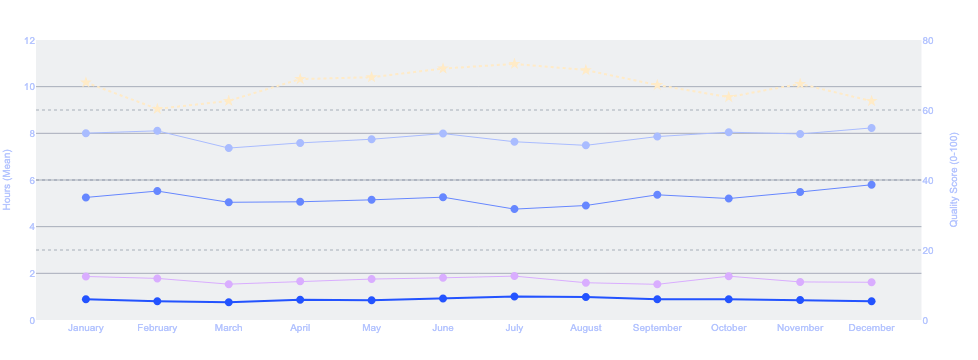

In [22]:
# Monthly mean trend of sleep stages
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']
fig = create_sleep_trend_chart(df, 'month_name', months, 'Sleep Stages and Quality Score across Months')

fig.write_html("monthly_line_chart.html", include_plotlyjs='cdn', config={'displayModeBar': False})

fig.show()

In [23]:
# Quality score distribution for months
from ipywidgets import interact, Checkbox

@interact(
    flatten_intervals=Checkbox(
        value=False,
        description='Flatten to intervals'
    )
)
def show_monthly_stacked(flatten_intervals):
    months = ['January', 'February', 'March', 'April', 'May', 'June', 
              'July', 'August', 'September', 'October', 'November', 'December']
    
    if flatten_intervals:
        fig = create_interval_stacked_bars(
            df, 'month_name', months,
            'Sleep Score intervals % Distribution across Months'
        )
    else:
        fig = create_individual_day_stacked_bars(
            df, 'month_name', months, 
            'Sleep Scores Individual Days distribition across Months',
            normalize=True
        )

    # Add custom HTML/CSS to center the chart
    html_string = fig.to_html(include_plotlyjs='cdn', config={'displayModeBar': False})
    
    # Inject centering CSS
    centered_html = html_string.replace(
        '<body>',
        '<body style="display: flex; justify-content: center; align-items: center; margin: 0; padding: 0; min-height: 100vh;">'
    )
    
    # Write to file
    with open("monthly_bar_chart.html", "w") as f:
        f.write(centered_html)
    
    fig.show()

interactive(children=(Checkbox(value=False, description='Flatten to intervals'), Output()), _dom_classes=('wid…

## Irma analysis

In [24]:
# Irma cycle on radial plot
from ipywidgets import interact, Dropdown

# Get available years
available_years = sorted(df['year'].unique())

# Create interactive widget
@interact(year=Dropdown(
    options=[(str(y), y) for y in available_years],
    value=available_years[-1],  # Default to most recent year
    description='Year:'
))
def show_calendar(year):
    fig = create_radial_bar_calendar(
        df=df,
        metric_column='overall_score',
        year=int(year),
        title=f'Sleep Quality Score - {year}',
    )
    if fig:
        fig.show()

interactive(children=(Dropdown(description='Year:', index=2, options=(('2023', np.int32(2023)), ('2024', np.in…

In [25]:
# Quality scores distribution for Irma phases
from ipywidgets import interact, Checkbox

# Cycle phase stacked bars with toggle
@interact(
    flatten_intervals=Checkbox(
        value=False,
        description='Flatten to intervals'
    )
)
def show_cycle_stacked(flatten_intervals):
    phases = ['Free', 'Eggy', 'PMS', 'Irma']
    
    if flatten_intervals:
        fig = create_interval_stacked_bars(
            df, 'cycle_category', phases,
            'Sleep Score Distribution by Cycle Phase (%)',
            height=200,
        )
    else:
        fig = create_individual_day_stacked_bars(
            df, 'cycle_category', phases,
            'Sleep Scores by Cycle Phase (Individual Days)',
            height=200,
            normalize=True  
        )

    # Add custom HTML/CSS to center the chart
    html_string = fig.to_html(include_plotlyjs='cdn', config={'displayModeBar': False})
    
    # Inject centering CSS
    centered_html = html_string.replace(
        '<body>',
        '<body style="display: flex; justify-content: center; align-items: center; margin: 0; padding: 0; min-height: 100vh;">'
    )
    
    # Write to file
    with open("irma_bar_chart.html", "w") as f:
        f.write(centered_html)
    
    fig.show()

interactive(children=(Checkbox(value=False, description='Flatten to intervals'), Output()), _dom_classes=('wid…